<a href="https://colab.research.google.com/github/fecmarinho/logica-fuzzy/blob/main/Trabalho1_Logica_Fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author*: Cristian Muñoz Villalobos

In [ ]:
!wget https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/fuzzy_rules.py
!wget https://raw.githubusercontent.com/fecmarinho/logica-fuzzy/main/2113130-serie.txt
!pip install scikit-fuzzy

--2021-11-19 13:39:59--  https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/fuzzy_rules.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4794 (4.7K) [text/plain]
Saving to: ‘fuzzy_rules.py’

fuzzy_rules.py      100%[===================>]   4.68K  --.-KB/s    in 0s      

2021-11-19 13:39:59 (65.6 MB/s) - ‘fuzzy_rules.py’ saved [4794/4794]

--2021-11-19 13:39:59--  https://raw.githubusercontent.com/fecmarinho/logica-fuzzy/main/2113130-serie.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1174 (1.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import datetime
import pprint
import os

from operator import itemgetter
from itertools import groupby
from datetime import timedelta, date

from skfuzzy import control as ctrl
from fuzzy_rules import extract_rules,config_input_variable,config_output_variable,define_input_variables,define_output_variables,read_dataset
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
! cat 2113130-serie.txt | head -10 

1,28
1,33
1,3
1,33
1,32
1,29
1,27
1,29
1,31
1,28


Text(0, 0.5, 'value')

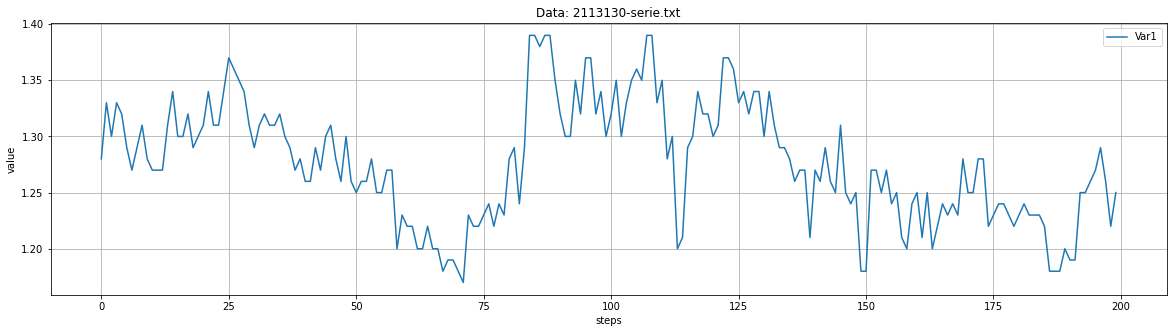

In [ ]:
file_path='2113130-serie.txt'
data = read_dataset(file_path)
plt.figure(figsize=(20,5))
plt.title('Data: {}'.format(file_path))
plt.plot(data)
plt.grid()
plt.legend(['Var1','Var2','Var3'])
plt.xlabel('steps')
plt.ylabel('value')

Preprocessamento

In [ ]:
steps_forward=1
windows_size=7
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.window(windows_size + steps_forward, shift=1, drop_remainder=True)
dataset = np.stack([list(window_dataset) for window_dataset in dataset], axis=0)
X,y_true = dataset[:,:-steps_forward,0],dataset[:,-steps_forward:][:,-1,:]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.20, shuffle=False)

print('-'*21+'\nDataset Distribution\n'+'-'*21)
print('X\t:{} | y_true\t:{}'.format(X.shape,y_true.shape))
print('X_train\t:{} | y_train\t:{}'.format(X_train.shape,y_train.shape))
print('X_test\t:{}  | y_test\t:{}'.format(X_test.shape,y_test.shape))

---------------------
Dataset Distribution
---------------------
X	:(193, 7) | y_true	:(193, 1)
X_train	:(154, 7) | y_train	:(154, 1)
X_test	:(39, 7)  | y_test	:(39, 1)


In [ ]:
x_min_value = X.min(axis=0)
x_max_value = X.max(axis=0)
y_min_value = y_true.min(axis=0)
y_max_value = y_true.max(axis=0)

nb_inputs = X_train.shape[-1]
nb_outputs = y_train.shape[-1]

aggregation_opt={
'and_func':np.fmin,
'or_func': np.fmax
}

config = {
    
# Variable Parameters
'nb_inputs' : nb_inputs,
'nb_outputs': nb_outputs,
'nb_sets':[[5]*nb_inputs, [5]*nb_outputs],
'min':[x_min_value,y_min_value],
'max':[x_max_value,y_max_value],
'shoulder':True,

# Fuzzy System Parameters
'defuzzify_method':'mom',
'aggregation_opt': aggregation_opt,

#Other Parametres
'resolution':1000,
'epsilon':0.0001
}

pp = pprint.PrettyPrinter(depth=6)
pp.pprint(config)
pp.pprint(aggregation_opt)

{'aggregation_opt': {'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>},
 'defuzzify_method': 'mom',
 'epsilon': 0.0001,
 'max': [array([1.39, 1.39, 1.39, 1.39, 1.39, 1.39, 1.39]), array([1.39])],
 'min': [array([1.17, 1.17, 1.17, 1.17, 1.17, 1.17, 1.17]), array([1.17])],
 'nb_inputs': 7,
 'nb_outputs': 1,
 'nb_sets': [[5, 5, 5, 5, 5, 5, 5], [5]],
 'resolution': 1000,
 'shoulder': True}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}


In [ ]:
antecedents = define_input_variables(config, shoulder=config['shoulder'])
consequents = define_output_variables(config, shoulder=config['shoulder'], defuzzify_method=config['defuzzify_method'])
print(antecedents)
print(consequents)

[Antecedent: I_1, Antecedent: I_2, Antecedent: I_3, Antecedent: I_4, Antecedent: I_5, Antecedent: I_6, Antecedent: I_7]
[Consequent: O_1]


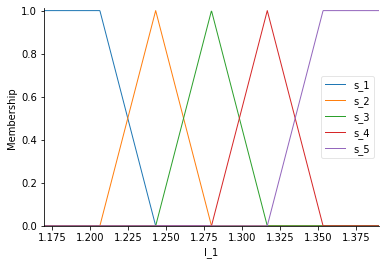

In [ ]:
antecedents[0].view()

In [ ]:
rules,df_rules = extract_rules(config, antecedents, consequents, X_train, y_train)
print('number of rules:', len(df_rules))

number of rules: 141


In [ ]:
df_rules.head(10)

,I_1,I_2,I_3,I_4,I_5,I_6,I_7,O_1,Dr
0,s_1,s_1,s_1,s_1,s_1,s_1,s_1,s_2,0.637602
1,s_1,s_1,s_1,s_1,s_1,s_1,s_2,s_1,0.404799
2,s_1,s_1,s_1,s_1,s_1,s_2,s_1,s_1,0.256998
3,s_1,s_1,s_1,s_1,s_2,s_1,s_1,s_2,0.163862
4,s_1,s_1,s_1,s_2,s_1,s_1,s_2,s_2,0.149128
5,s_1,s_1,s_2,s_1,s_1,s_2,s_2,s_1,0.094678
6,s_1,s_1,s_2,s_2,s_1,s_2,s_2,s_3,0.085906
7,s_1,s_1,s_3,s_3,s_2,s_3,s_2,s_2,0.234167
8,s_1,s_1,s_3,s_4,s_5,s_4,s_4,s_4,0.103087
9,s_1,s_2,s_1,s_1,s_1,s_1,s_1,s_1,0.163162


In [ ]:
%time system = ctrl.ControlSystem(rules)

CPU times: user 23.6 s, sys: 81.8 ms, total: 23.7 s
Wall time: 23.8 s


In [ ]:
%time sim = ctrl.ControlSystemSimulation(system)

CPU times: user 349 µs, sys: 5 µs, total: 354 µs
Wall time: 366 µs


In [ ]:
def evaluate_model(sim, x_data, y_data, return_results=False):
  y_prev = []
  for x in x_data:
      for i,x_i in enumerate(x,1):
          sim.input['I_{}'.format(i)]=x_i
      sim.compute()
      result = sim.output['O_1']
      y_prev.append(result)
      
  mse = mean_squared_error(y_data, y_prev)
  
  print('mean_squared_error: {}'.format(mse))

  plt.figure(figsize=(15,5))
  plt.plot(y_data,'*')
  plt.plot(y_prev,'s')
  plt.show()

  y_data, y_prev = np.squeeze(np.array(y_data)), np.array(y_prev)
  table_results = pd.DataFrame()
  table_results['Real']=y_data
  table_results['Predicted']=y_prev
  table_results['Diference']=np.abs(y_data - y_prev) 
  table_results['Diference (%)']=np.abs((y_data - y_prev) / y_data)
  if return_results:
    return table_results

mean_squared_error: 0.0005144226260511727


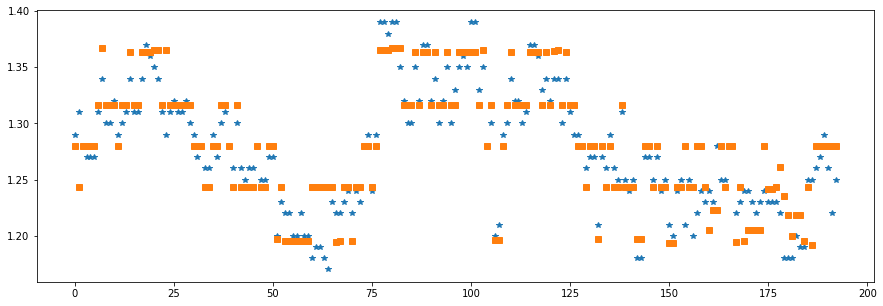

In [ ]:
results=evaluate_model(sim, X, y_true, return_results=True)

In [ ]:
results.head()

,Real,Predicted,Diference,Diference (%)
0,1.29,1.280109,0.009891,0.007667
1,1.31,1.243366,0.066634,0.050866
2,1.28,1.280065,0.000065,0.000051
3,1.27,1.280000,0.010000,0.007874
4,1.27,1.280110,0.010110,0.007961


mean_squared_error: 0.0003726431205907374


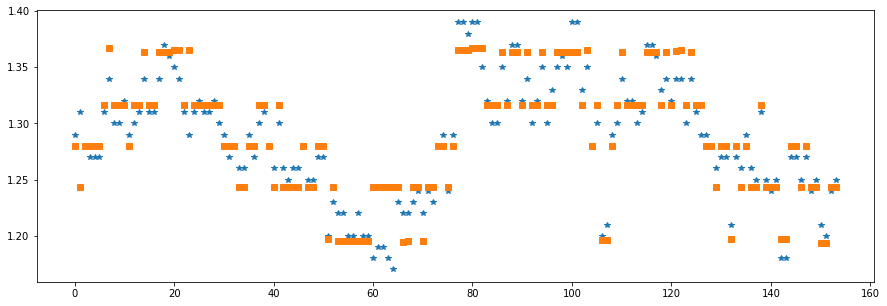

In [ ]:
evaluate_model(sim, X_train, y_train)

mean_squared_error: 0.0010742699040231477


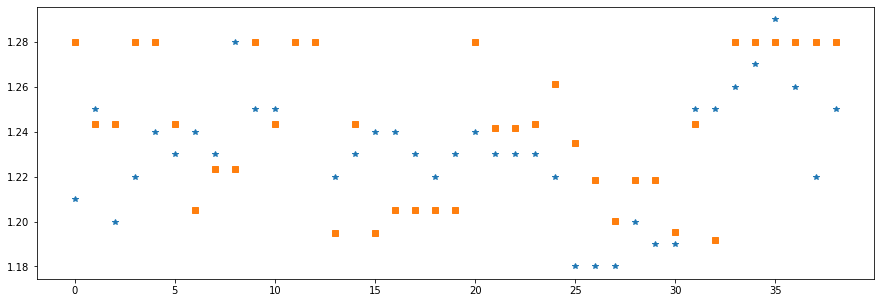

In [ ]:
evaluate_model(sim, X_test, y_test)